In [7]:
%run init_notebook.py

In [8]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [10]:
# Load data
data_len = 1560

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [94]:
# predicted is y col
data_dict["model_features"].update(predicted="sp_close_lead14")

# correlation

In [95]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
     'aaii_Bearish',
     'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     # 'sp_close_lag2',
     # 'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
]

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [96]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [97]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]] ,#+ ["sp_close"],
              data_dict["model_features"]["predicted"],
              show_plot=False,
             figsize=(5, 3))

[['vixo', 8, 0.043],
 ['ff_M_RF', 1, 0.08],
 ['ff_SMB', 8, 0.065],
 ['ff_HML', 7, 0.081],
 ['ff_RMW', 7, 0.045],
 ['ff_CMA', 2, 0.044],
 ['termspread', 1, 0.038],
 ['aaii_Bullish', 3, 0.078],
 ['aaii_Bearish', 1, 0.047],
 ['aaii_Neutral', 3, 0.083]]

In [98]:
df_ws, _ = shift_var_relative_to_df(df_ws,
                                 shift_var=["ff_SMB"],
                                 no_lags=[4])
data_dict["data_transformation"].update(shift_var=_)
df_ws = df_ws.dropna()

# Multicolinerarity

,VIF,corr_sp_close_lead14
ff_HML,1.389761,-0.058467
ff_SMB,1.015012,-0.041671
vixo,1.774057,-0.041652
ff_CMA,1.534833,-0.028975
ff_M_RF,2.427641,-0.021245
aaii_Bullish,4.221094,-0.014302
aaii_Bearish,3.848568,-0.008029
termspread,1.034254,-0.004861
sp_close_lag1,4.319467,-0.000723
sp_close,5.398558,0.027704


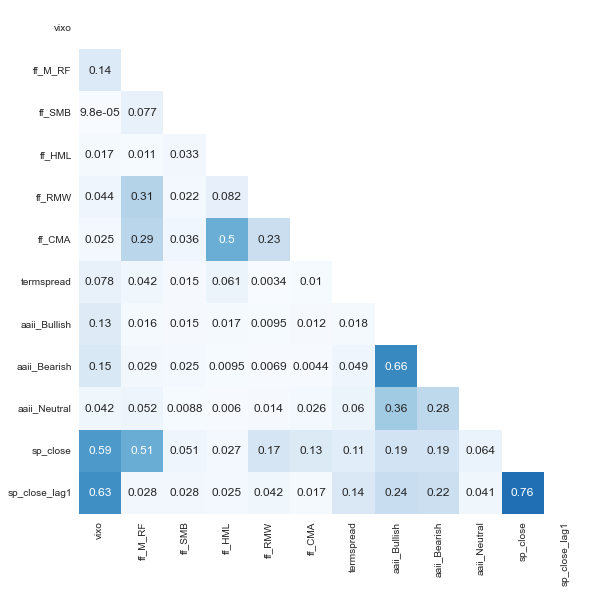

In [99]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["model_features"]["predicted"])

# Regression

In [100]:
df_train = df_ws.copy()

In [101]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.2,
                                            add_const=False)

In [102]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [103]:
model.results_.pvalues < .05
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)

In [104]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sp_close_lead14   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.075
Date:                Sun, 13 Mar 2022   Prob (F-statistic):             0.0160
Time:                        20:44:39   Log-Likelihood:                 2994.6
No. Observations:                1269   AIC:                            -5963.
Df Residuals:                    1256   BIC:                            -5896.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo             -0.0043      0.007     -0.591      0.555      -0.019       0.010
ff_M_RF          -0.0019      0.001     -2.169      0.030      -0.004      -0.000
ff_SMB           -0.0017      0.001     -1.451      0.147      -0.004       0.001
ff_HML           -0.0028      0.001     -2.198      0.028      -0.005      -0.000
ff_RMW            0.0029      0.001      1.991      0.047    4.21e-05       0.006
ff_CMA           -0.0002      0.002     -0.094      0.925      -0.004       0.004
termspread       -0.0006      0.004     -0.139      0.889      -0.009       0.008
aaii_Bullish      0.0022      0.006      0.364      0.716      -0.010       0.014
aaii_Bearish      0.0038      0.004      0.860      0.390      -0.005       0.013
aaii_Neutral      0.0071      0.004      1.614      0.107      -0.002       0.016
sp_close          0.1276      0.064      2.001      0.046       0.002       0.253
sp_close_lag1    -0.1063      0.059     -1.813      0.070      -0.221       0.009
intercept         0.0016      0.001      2.434      0.015       0.000       0.003
==============================================================================
Omnibus:                      164.579   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.840
Skew:                          -0.544   Prob(JB):                    3.25e-154
Kurtosis:                       6.491   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

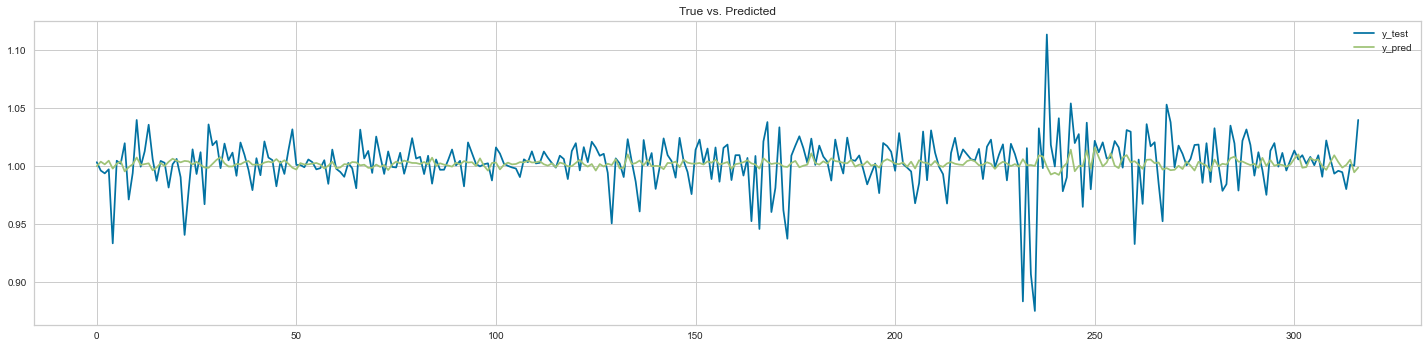

Validation Scores
mean squared error: 0.000499
mean absolute error: 0.014929
R2: 0.003297


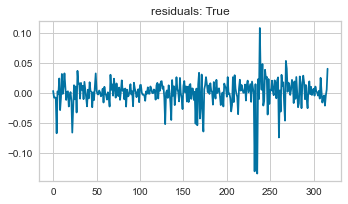

Stationarity Test Results
P-Values: 5.130647636749519e-30
Test-stats: -17.372094821652627
Time series is stationary: True


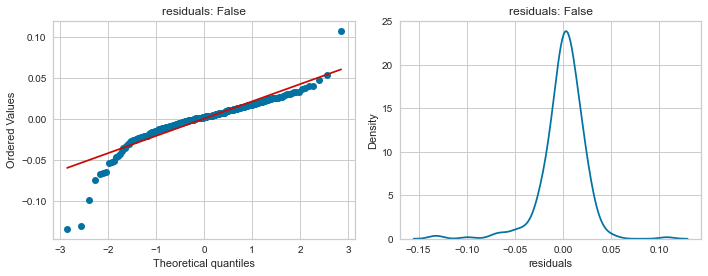

Normality Test Results
P-Values: 4.35356565436208e-31
Test-stats: 139.81828536563958
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


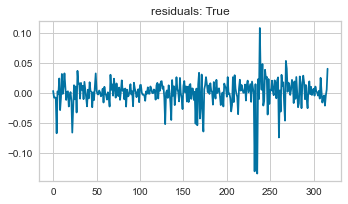

Test for Heteroskedasticity
Test p-value: 0.0001645218413440584
Heteroskedasticity is present: True


In [105]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(
    X_train=X_train,
    y_train=y_train,
    X_validate=X_test,
    y_validate=y_test,
    model=model_)

mval.get_model_performance()
stat, norm, hetero = mval.analyse_resids(print_results=True)

#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

<module 'matplotlib.pyplot' from 'C:\\Users\\LukasGrahl\\Documents\\GIT\\bachelor\\bachelor_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

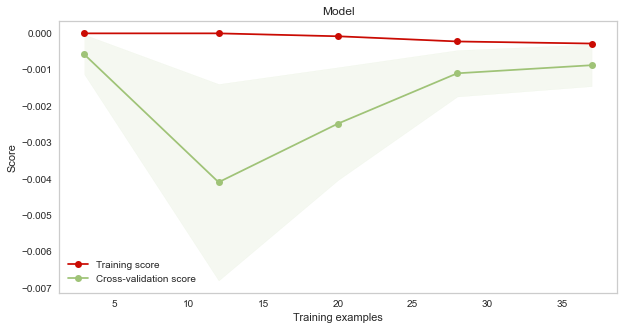

In [106]:
mval.sm_learning_curve("Model", n_splits=8)

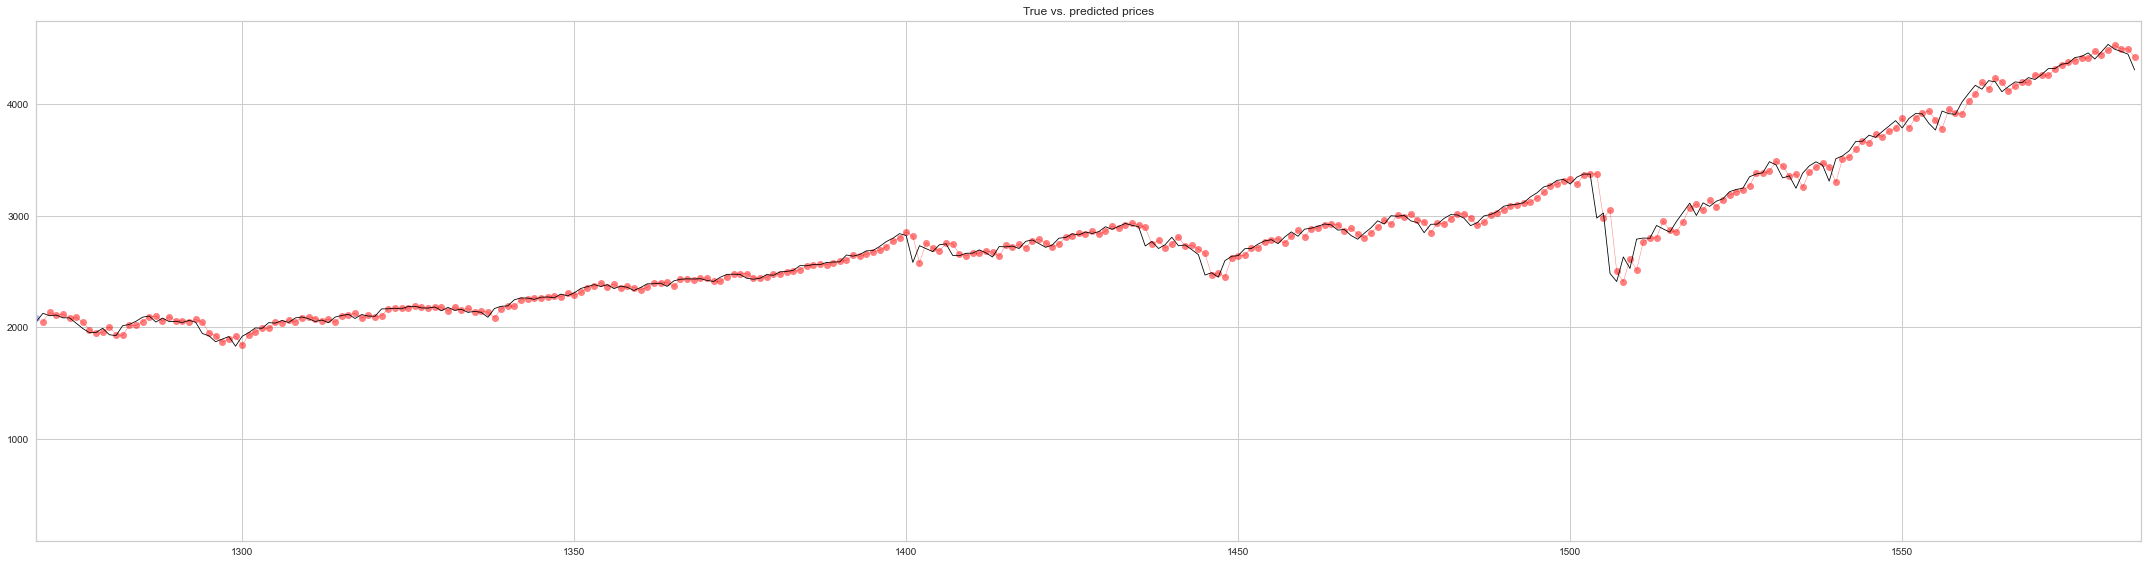

Validation Scores Test Data
mean squared error: 4569.61254
mean absolute error: 41.529508
mean absolute error in %: 0.029517162309814913
r2: 0.989451


In [107]:
mval.plot_results_on_price_scale(df_w,
                                 df_ws,
                                 sp_true_vals=data_dict["data"]["sp_true_vals"],
                                 show_pred_only=True)

# Save model

In [68]:
save_model(df_train, model, data_dict, name=f"ols_{data_len}_{data_dict['model_features']['predicted']}", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-13_ols_1560_sp_close_lead4_model.pkl"? (y/n)


 y
